# Лабораторная работа 4. Подбор параметров и работа с данными

## Линейная регрессия

In [44]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import urllib.request

В данном задании мы рассмотрим стандартный датасет для задачи регрессии `Boston Housing`, в котором необходимо предсказать стоимость недвижимости по 13 признакам.

In [45]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"

feature_lines = urllib.request.urlopen(data_url).readlines()[7:21]
columns = []
for el in feature_lines:
    columns.append(el.split()[0].strip().decode('UTF-8'))

In [46]:
df = pd.read_csv(data_url, sep='\s+', skiprows=21, header=None)

values_w_nulls = df.values.flatten()
all_values = values_w_nulls[~np.isnan(values_w_nulls)]

df = pd.DataFrame(data = all_values.reshape(-1, len(columns)), columns = columns)

df

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\giezz\AppData\Local\Temp\ipykernel_11148\3399746295.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(data_url, sep='\s+', skiprows=21, header=None)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [47]:
y = df["MEDV"]
df = df.drop(columns=["MEDV"])
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.9,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14


Разделим выборку на обучающую и тестовую в отношении 8/2:

In [48]:
x_train, x_test, y_train, y_test = train_test_split(df, y, train_size=0.8, random_state=42)

__Задание 1.__ Обучение линейной регрессии.

Обучите стандартную линейную регрессию, а также с $L_1$ и $L_2$ регуляризаторами (используйте параметры по умолчанию). Посчитайте метрику $R^2$ для каждого метода (метод `score`).

In [49]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
r2_linear = linear_model.score(x_test, y_test)

lasso_model = Lasso()
lasso_model.fit(x_train, y_train)
r2_lasso = lasso_model.score(x_test, y_test)

ridge_model = Ridge()
ridge_model.fit(x_train, y_train)
r2_ridge = ridge_model.score(x_test, y_test)

print(f"R^2 для обычной линейной регрессии: {r2_linear:.4f}")
print(f"R^2 для L1-регуляризации (Lasso): {r2_lasso:.4f}")
print(f"R^2 для L2-регуляризации (Ridge): {r2_ridge:.4f}")

R^2 для обычной линейной регрессии: 0.6688
R^2 для L1-регуляризации (Lasso): 0.6671
R^2 для L2-регуляризации (Ridge): 0.6662


__Задание 2.__ Подбор гиперпараметров.

Для Lasso- и Ridge-регресий подберите коэффициент регуляризации по обучающей выборке с помощью кросс-валидации. Параметры для перебора возьмите по логарифмической сетке от $10^{-6}$ до $10^6$).
Также посчитайте метрику $R^2$ для тестовой выборки и сравните с предыдущими результатами. Заметно ли изменилось качество?

Useful: GridSearchCV, RidgeCV, LassoCV

In [65]:
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import r2_score

splitter = KFold(n_splits=10, shuffle=True, random_state=42)

alphas = np.logspace(-6, 6, 13)
print(alphas)
max_iter = 100_000

ridge = Ridge()
ridge_grid = GridSearchCV(ridge, param_grid={'alpha': alphas}, cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring='r2')
ridge_grid.fit(x_train, y_train)
ridge_best_alpha = ridge_grid.best_params_['alpha']
ridge_best_model = ridge_grid.best_estimator_

ridge_cv = RidgeCV(alphas=alphas, cv=splitter)
ridge_cv.fit(x_train, y_train)

lasso = Lasso(max_iter=max_iter)
lasso_grid = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=KFold(n_splits=10, shuffle=True, random_state=42), scoring='r2')
lasso_grid.fit(x_train, y_train)
lasso_best_alpha = lasso_grid.best_params_['alpha']
lasso_best_model = lasso_grid.best_estimator_


lasso_cv = LassoCV(alphas=alphas, cv=KFold(n_splits=10, shuffle=True, random_state=42), max_iter=max_iter)
lasso_cv.fit(x_train, y_train)

ridge_r2 = r2_score(y_test, ridge_best_model.predict(x_test))
lasso_r2 = r2_score(y_test, lasso_best_model.predict(x_test))

ridge_cv_r2 = r2_score(y_test, ridge_cv.predict(x_test))
lasso_cv_r2 = r2_score(y_test, lasso_cv.predict(x_test))

print("Ridge (GridSearchCV): alpha =", ridge_best_alpha, ", R^2 test =", ridge_r2)
print("Ridge (RidgeCV): alpha =", ridge_cv.alpha_, ", R^2 test =", ridge_cv_r2)
print("Lasso (GridSearchCV): alpha =", lasso_best_alpha, ", R^2 test =", lasso_r2)
print("Lasso (LassoCV): alpha =", lasso_cv.alpha_, ", R^2 test =", lasso_cv_r2)

[1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03
 1.e+04 1.e+05 1.e+06]
Ridge (GridSearchCV): alpha = 0.1 , R^2 test = 0.7401585480686115
Ridge (RidgeCV): alpha = 0.1 , R^2 test = 0.7401585480686115
Lasso (GridSearchCV): alpha = 0.0001 , R^2 test = 0.7406004629053804
Lasso (LassoCV): alpha = 1e-06 , R^2 test = 0.7406079229688961


Постройте график зависимости $R^2$ для обучающей и тестовой (на кросс-валидации) выборок в зависимости от значения гиперпараметра. Для Lasso также постройте график зависимости количества ненулевых весов.

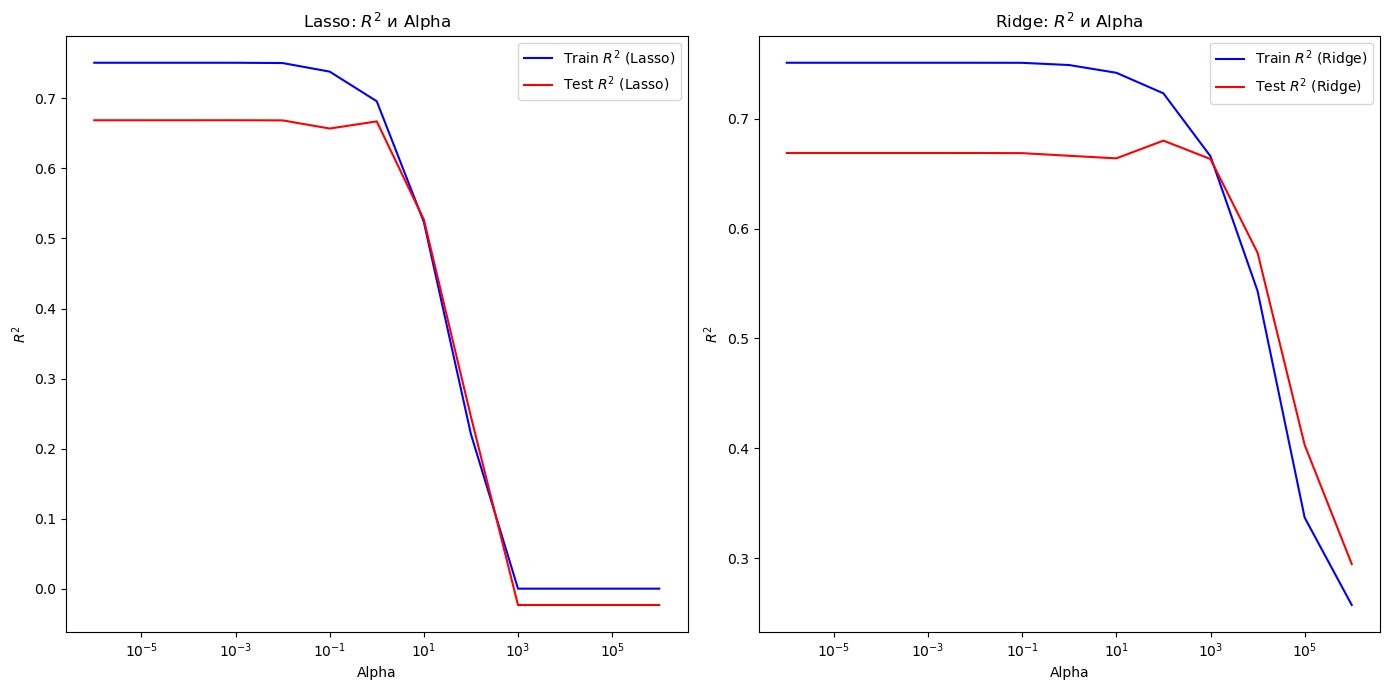

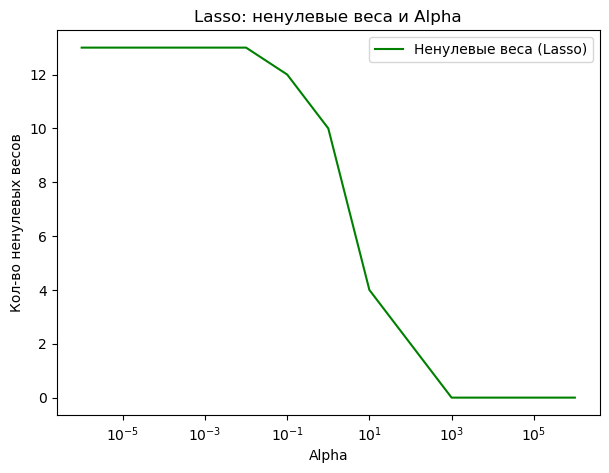

In [51]:
lasso_r2_train = []
lasso_r2_val = []
lasso_nonzero_weights = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso_model.fit(x_train, y_train)
    lasso_r2_train.append(lasso_model.score(x_train, y_train))
    lasso_r2_val.append(lasso_model.score(x_test, y_test))
    lasso_nonzero_weights.append(np.sum(lasso_model.coef_ != 0))

ridge_r2_train = []
ridge_r2_val = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha, max_iter=10000)
    ridge_model.fit(x_train, y_train)
    ridge_r2_train.append(ridge_model.score(x_train, y_train))
    ridge_r2_val.append(ridge_model.score(x_test, y_test))

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(alphas, lasso_r2_train, label="Train $R^2$ (Lasso)", color="blue")
plt.plot(alphas, lasso_r2_val, label="Test $R^2$ (Lasso)", color="red")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("$R^2$")
plt.title("Lasso: $R^2$ и Alpha")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alphas, ridge_r2_train, label="Train $R^2$ (Ridge)", color="blue")
plt.plot(alphas, ridge_r2_val, label="Test $R^2$ (Ridge)", color="red")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("$R^2$")
plt.title("Ridge: $R^2$ и Alpha")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(alphas, lasso_nonzero_weights, label="Ненулевые веса (Lasso)", color="green")
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Кол-во ненулевых весов")
plt.title("Lasso: ненулевые веса и Alpha")
plt.legend()
plt.show()

В какой момент происходит недообучение? Почему?

__Ответ__: Недообучение происходит при значениях параметра альфа приблизительно выше 0.5.

---

## Подготовка данных

Как вы могли заметить, большого прироста качества с помощью подбора коэфициента регуляризации добиться не удалось. Поэтому прежде чем бросаться обучать модели, необходимо изучить и предобработать данные.

__Задание 3.__ Масштабирование.

Зачастую признаки в сырых данных имеют разный масштаб. Попробуйте применить масштабирование к данным, сравните качество. Заметно ли изменение?

Pipeline, StandardScaler, MinMaxScaler

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
pipeline_standard_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(alphas=alphas, cv=splitter))
])

pipeline_standard_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=alphas, cv=splitter))
])

pipeline_standard_lasso.fit(x_train, y_train)
pipeline_standard_ridge.fit(x_train, y_train)

lasso_best_alpha = pipeline_standard_lasso.named_steps["lasso"].alpha_
ridge_best_alpha = pipeline_standard_ridge.named_steps["ridge"].alpha_

r2_lasso_standard = pipeline_standard_lasso.score(x_test, y_test)
r2_ridge_standard = pipeline_standard_ridge.score(x_test, y_test)

print(f"StandardScaler: Лучший alpha для Lasso: {lasso_best_alpha:.6f}, R^2: {r2_lasso_standard:.4f}")
print(f"StandardScaler: Лучший alpha для Ridge: {ridge_best_alpha:.6f}, R^2: {r2_ridge_standard:.4f}")

pipeline_minmax_lasso = Pipeline([
    ("scaler", MinMaxScaler()),
    ("lasso", LassoCV(alphas=alphas, cv=splitter))
])

pipeline_minmax_ridge = Pipeline([
    ("scaler", MinMaxScaler()),
    ("ridge", RidgeCV(alphas=alphas, cv=splitter))
])

pipeline_minmax_lasso.fit(x_train, y_train)
pipeline_minmax_ridge.fit(x_train, y_train)

lasso_best_alpha_minmax = pipeline_minmax_lasso.named_steps["lasso"].alpha_
ridge_best_alpha_minmax = pipeline_minmax_ridge.named_steps["ridge"].alpha_

r2_lasso_minmax = pipeline_minmax_lasso.score(x_test, y_test)
r2_ridge_minmax = pipeline_minmax_ridge.score(x_test, y_test)

print(f"MinMaxScaler: Лучший alpha для Lasso: {lasso_best_alpha_minmax:.6f}, R^2: {r2_lasso_minmax:.4f}")
print(f"MinMaxScaler: Лучший alpha для Ridge: {ridge_best_alpha_minmax:.6f}, R^2: {r2_ridge_minmax:.4f}")

StandardScaler: Лучший alpha для Lasso: 0.001000, R^2: 0.6687
StandardScaler: Лучший alpha для Ridge: 10.000000, R^2: 0.6660
MinMaxScaler: Лучший alpha для Lasso: 0.001000, R^2: 0.6688
MinMaxScaler: Лучший alpha для Ridge: 0.100000, R^2: 0.6700


Сравните оптимальное значение коэффициента регуляризации для Ridge-регрессии до и после масштабирования. Изменилось ли оно? Предположите, почему так могло произойти.

In [53]:
print(f"MinMaxScaler: Лучший alpha для Ridge: {ridge_best_alpha_minmax:.6f}, Лучший alpha для Ridge: {ridge_best_alpha:.6f}")

MinMaxScaler: Лучший alpha для Ridge: 0.100000, Лучший alpha для Ridge: 10.000000


Потому что штрафующий коэффициент зависит от масштаба данных

__Задание 4.__ Новые признаки.

Полезным также бывает посмотреть как целевая переменная зависит от каждого признака.

In [54]:
%matplotlib inline
def pairplot(df, target):
    ncol, nrow = 7, df.shape[1] // 7 + (df.shape[1] % 7 > 0)
    plt.figure(figsize=(ncol * 4, nrow * 4))

    for i, feature in enumerate(df.columns):
        plt.subplot(nrow, ncol, i + 1)
        plt.scatter(df[feature], target, s=10, marker='o', alpha=.6)
        plt.xlabel(feature)
        if i % ncol == 0:
            plt.ylabel('target')

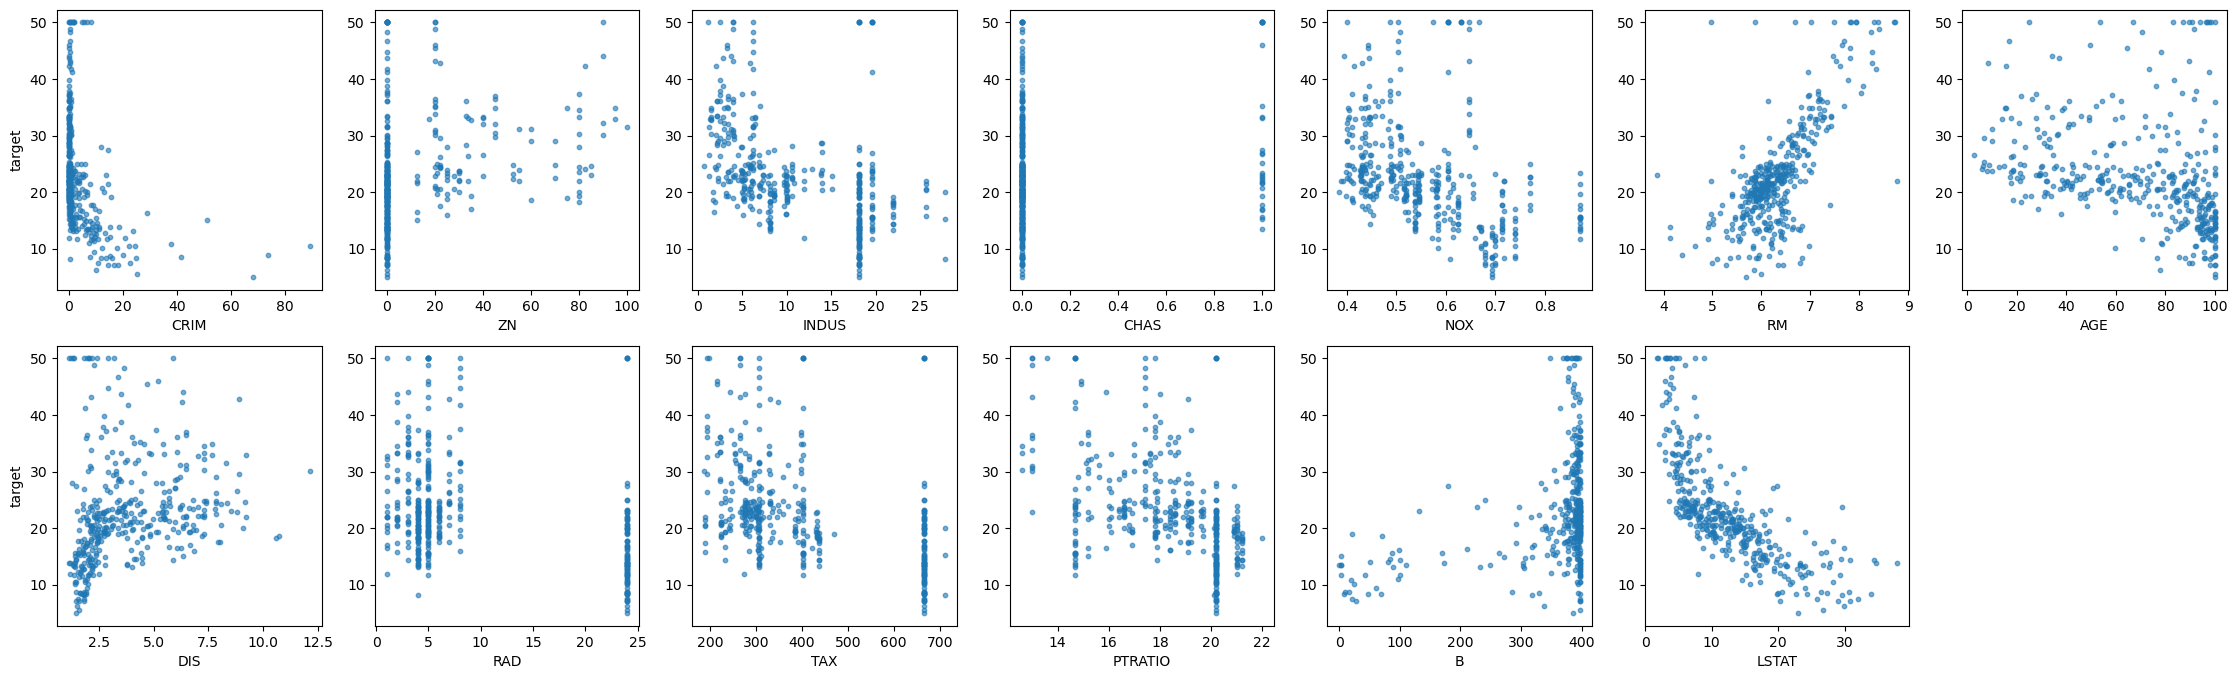

In [55]:
pairplot(x_train, y_train)
plt.show()

Обратите внимание на зависимость цены от признака `LSTAT`. Является ли эта зависимость линейной? А какой? Попробуйте выбрать преобразование для этого признака так, чтобы получившаяся зависимость была более линейной. Добейтесь $R^2$ на тестовой выборке не меньше 0.71.

In [56]:
x_train['LSTAT'] = np.log1p(x_train['LSTAT'])
x_test['LSTAT'] = np.log1p(x_test['LSTAT'])

In [57]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
r2_linear = linear_model.score(x_test, y_test)
print(f"R^2 для обычной линейной регрессии: {r2_linear:.4f}")

R^2 для обычной линейной регрессии: 0.7406


Помимо преобразований отдельных признаков полезными бывают их попарные взаимодействия. Воспользуйтесь PolynomialFeatures, чтобы добавить попарные произведения и квадраты всех признаков. Обучите Ridge-регрессию (подберите гиперпараметр!) и посчитайте $R^2$ на тесте. Сильно ли изменилось качество?

In [58]:
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = Ridge()

ridge_cv = GridSearchCV(ridge, param_grid, scoring='r2', cv=splitter)
ridge_cv.fit(x_train_poly, y_train)

best_alpha = ridge_cv.best_params_['alpha']
print(f'Лучшее значение alpha: {best_alpha}')
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(x_train_poly, y_train)

y_pred_test = ridge_best.predict(x_test_poly)

r2_test = r2_score(y_test, y_pred_test)
print(f'R^2 на тестовой выборке: {r2_test:.2f}')

Лучшее значение alpha: 100
R^2 на тестовой выборке: 0.81


__Задание 5.__ Оптимальная архитектура, анализ.

При помощи `Pipeline` и `GridSearchCV` выберите оптимальную архитектуру, комбинируя различные методы масштабирования, степень полинома в `PolynomialFeatures`, а также регуляризаторы. Для `Lasso` поставьте максимальное количество итераций больше значения по умолчанию, чтобы оптимизация сошлась.

In [59]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures()),
    ('regressor', Lasso())
])

param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'poly__degree': [1, 2, 3],
    'poly__include_bias': [False],
    'regressor': [Ridge(), Lasso(max_iter=5000)],
    'regressor__alpha': [0.01, 0.1, 1, 10, 100],
}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='r2',
    cv=splitter,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
print(f'Лучший R^2 на кросс-валидации: {grid_search.best_score_:.4f}')

best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(x_test)
r2_test = r2_score(y_test, y_pred_test)
print(f'R^2 на тестовой выборке: {r2_test:.4f}')

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Лучшие параметры: {'poly__degree': 3, 'poly__include_bias': False, 'regressor': Ridge(), 'regressor__alpha': 0.1, 'scaler': MinMaxScaler()}
Лучший R^2 на кросс-валидации: 0.8739
R^2 на тестовой выборке: 0.8455


Для одной комбинации метода масштабирования и линейной регрессии постройте зависимость метрики $R^2$ на кросс-валидации (`GridSearchCV.cv_results_['mean_test_score']`) от значения параметра регуляризации для различных степеней полиномов в `PolynomialFeatures`.

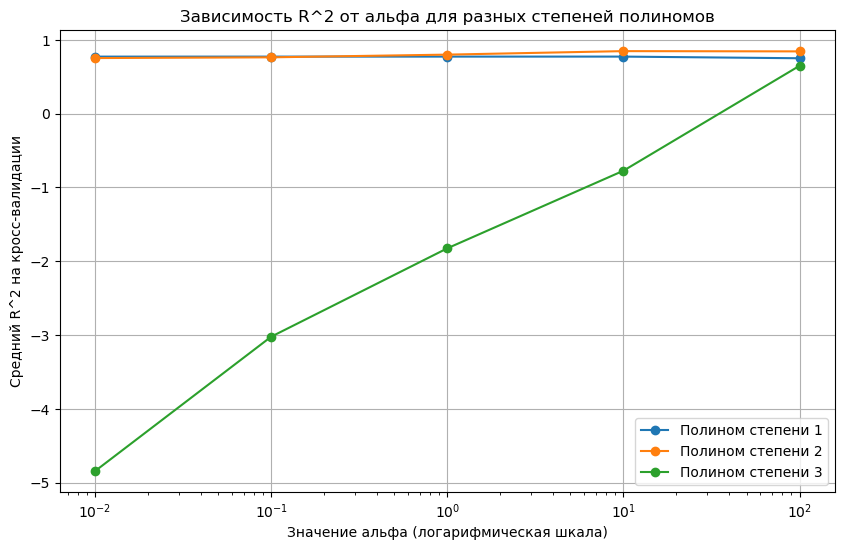

In [60]:
alphas = [0.01, 0.1, 1, 10, 100]
degrees = [1, 2, 3]
results = {}

for degree in degrees:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree)),
        ('model', Ridge())
    ])

    param_grid = {'model__alpha': alphas}

    grid_search = GridSearchCV(pipeline, param_grid, cv=splitter, scoring='r2', return_train_score=True)
    grid_search.fit(x_train, y_train)

    results[degree] = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
for degree, scores in results.items():
    plt.plot(alphas, scores, label=f'Полином степени {degree}', marker='o')

plt.xscale('log')
plt.legend()
plt.xlabel('alpha')
plt.xlabel('Значение альфа (логарифмическая шкала)')
plt.ylabel('Средний R^2 на кросс-валидации')
plt.title('Зависимость R^2 от альфа для разных степеней полиномов')
plt.legend()
plt.grid()
plt.show()


При каких значениях происходит переобучение? А недообучение? Почему?

__Ответ:__ Переобучение происходит при значениях полинома 1 и 2 степени, при значении степени полинома = 3, переобучение модели происходит при альфа ~100